In [5]:
import datasource as ds
import passencoder as pss
import pandasql as ps
import pandas as pd
u, p = pss.load_userpwd(r'C:\Users\razamo3\Documents\pass')



import numpy as np
import matplotlib.pyplot as plt
def plot_bar(df,xcol,ycol):
    # this is for plotting purpose
    index = np.arange(len(df.iloc[:,xcol]))
    plt.bar(index, df.iloc[:,ycol])
    #plt.xlabel('xlabel', fontsize=10)
    #plt.ylabel('ylabel', fontsize=10)
    plt.xticks(index, df.iloc[:,xcol], fontsize=10, rotation=90)
    #plt.title('title')
    plt.show()

### What info does SF table give about approved / funded ..etc

In [2]:
with ds.connect('dm',u,p) as con:
    q = """
          select b.approved_apps, b.Funded_Count_Msr, count(*)   

          from (select * 
          FROM [PBdm].[resl].[vw_FactSalesFunnel_Daily] 
          where [Fullapp_First_Submitted_Date_Key] > 20170430 and [Fullapp_First_Submitted_Date_Key] < 20171001 
          AND Channel_Key = 50 and Product_Key in (67,68,69,70,71,72,73,74,100)) as b
          group by b.approved_apps, b.Funded_Count_Msr"""
    
    countsummary = con.read_sql(q)
print(countsummary)
          
          

   approved_apps  Funded_Count_Msr       
0              0                 0   4944
1              1                 0   4323
2              1                 1  22060


### Initial Pull - SalesFunnel

```python
with ds.connect('dm',u,p) as con:
    q1 = """

      
       SELECT right(b.cust_num,9) as custnum, a.* 
       FROM [PBdm].[resl].[vw_FactSalesFunnel_Daily] as a 
       
       LEFT JOIN 
       
		  (SELECT * FROM [Pbdm].[resl].[vw_Applications_Daily] 
            WHERE Fullapp_First_Submitted_Date_Key > 20170430 AND Fullapp_First_Submitted_Date_Key < 20171001) as b
        
        ON a.Credit_Ref_Num = b.Credit_Ref_Num
          
        WHERE a.[Fullapp_First_Submitted_Date_Key] > 20170430 and a.[Fullapp_First_Submitted_Date_Key] < 20171001 
              AND a.Channel_Key = 50 and a.Product_Key in (67,68,69,70,71,72,73,74,100)

        """
    initialPull_table = con.read_sql(q1)

initialPull_table.to_pickle("tables/2a-initialpulltable.pkl")
```

In [6]:
initialPull_table = pd.read_pickle("tables/2a-initialpulltable.pkl")

### ListOfCustomers

In [7]:
### list of custnums that are approved and NOT funded at TD

temp1 = initialPull_table[(initialPull_table.Approved_Apps == 1) & (initialPull_table.Funded_Count_Msr == 0)]['custnum']
apprvd_not_funded_lst = str(tuple(temp1.tolist()))

### list of custnums that are approved and funded at TD

temp2 = initialPull_table[(initialPull_table.Approved_Apps == 1) & (initialPull_table.Funded_Count_Msr == 1)]['custnum']
apprvd_and_funded_lst = str(tuple(temp2.tolist()))

### list of custnums that are NOT approved and NOT funded at TD

temp3 = initialPull_table[(initialPull_table.Approved_Apps == 0) & (initialPull_table.Funded_Count_Msr == 0)]['custnum']
not_apprvd_not_funded_lst = str(tuple(temp3.tolist()))


temp4 = initialPull_table[(initialPull_table.Approved_Apps == 0) & (initialPull_table.Funded_Count_Msr == 1)]['custnum']
not_apprvd_but_funded_lst = str(tuple(temp4.tolist()))


In [8]:
apprvd_and_funded_lst

"('361698039', '202474143', '687151845', '205593957', '067805955', '501998022', '611027892', '286878762', '393390378', '364847571', '462035844', '648248805', '581133096', '352520784', '487182762', '597842136', '710645958', '503894997', '536517009', '481546062', '344064924', '495101916', '708349275', '543425733', '296036928', '466700517', '643883526', '379300482', '282404538', '710485425', '380331171', '546367014', '388165788', '246286512', '299560842', '393860367', '170364618', '483459966', '204330105', '380007873', '692843013', '550180944', '486052146', '484896843', '372912039', '580851432', '556334829', '320874192', '609813927', '566388153', '462838158', '648355464', '477716427', '651567069', '415520316', '636865974', '553812273', '160906914', '693651852', '125738028', '174271401', '355481361', '556178661', '207911079', '682893495', '108037116', '583618824', '588004884', '418534605', '379673937', '590946597', '455849055', '687051702', '483214896', '381741876', '635535747', '253098936

### Pulling Relevant CB data

#### Pulling approved not funded individuals

```python
with ds.connect('dm',u,p) as con:
    q2 = """
        SELECT Date_Key, cust_num, count(Prod_Ind) AS NoOfMTGs, sum(limit) as TotalLimit
        FROM [PBdm].[dbo].[Credit_Bureau]
        where cust_num IN %s AND prod_ind = 'MTG'
        group by cust_num, Date_Key, Prod_Ind
        
        """
    df2a = con.read_sql(q2 % apprvd_not_funded_lst)
df2a.to_pickle("tables/2b-df2a.pkl")
```

In [6]:
df2a = pd.read_pickle("tables/2b-df2a.pkl")

In [7]:
df2a

,Date_Key,cust_num,NoOfMTGs,TotalLimit
0,20160630,641145519,1,258000
1,20170430,539814816,1,53000
2,20171231,242233605,2,150000
3,20160630,556646346,1,218000
4,20160630,692284968,1,280000
5,20170430,462908394,1,129000
6,20170430,614452842,2,539000
7,20171231,584899254,2,223000
8,20160630,9468378,1,330000
9,20170430,258557841,2,595000


In [8]:
df2b = pd.pivot_table(df2a, values = ['NoOfMTGs', 'TotalLimit'], index =['cust_num'], columns =['Date_Key'])
df2 = df2b.fillna(0)

In [9]:
df2

NoOfMTGs                   TotalLimit                      
Date_Key  20160630 20170430 20171231   20160630   20170430   20171231
cust_num                                                             
770094         3.0      2.0      2.0   658000.0   398000.0   398000.0
1431279        1.0      1.0      1.0   195000.0   195000.0   195000.0
2320605        4.0      3.0      2.0   532000.0   425000.0   324000.0
2629476        0.0      1.0      1.0        0.0    96000.0    96000.0
3466359        2.0      2.0      2.0   410000.0   410000.0   410000.0
3872925        1.0      0.0      1.0    75000.0        0.0   353000.0
4836474        1.0      1.0      1.0   356000.0   356000.0   356000.0
4974192        2.0      2.0      1.0   426000.0   426000.0   210000.0
5990724        2.0      2.0      2.0   228000.0   228000.0   228000.0
8334864        2.0      2.0      2.0   468000.0   468000.0   590000.0
8771463        2.0      2.0      2.0   107000.0   120000.0   120000.0
8945091        2.0      2.0      1.0   307000.0   307000.0   130000.0
9468378        1.0      2.0      2.0   330000.0   684000.0   684000.0
11566512       2.0      2.0      2.0   360000.0   360000.0   360000.0
11736315       1.0      1.0      1.0   220000.0   220000.0   220000.0
12146085       1.0      1.0      1.0    61000.0    61000.0    61000.0
12436659       3.0      3.0      4.0   716000.0   716000.0  1101000.0
14382117       2.0      2.0      3.0   538000.0   538000.0   888000.0
14970816       0.0      0.0      1.0        0.0        0.0   340000.0
16704387       1.0      1.0      1.0   200000.0   200000.0   200000.0
16911333       1.0      1.0      1.0   252000.0   252000.0   252000.0
19900467       1.0      1.0      1.0   250000.0   250000.0   250000.0
20116476       2.0      2.0      4.0  1002000.0  1002000.0  1086000.0
20253942       0.0      0.0      1.0        0.0        0.0    35000.0
20900196       1.0      1.0      2.0   306000.0   306000.0   608000.0
21671487       1.0      0.0      0.0   100000.0        0.0        0.0
22823622       1.0      1.0      1.0   250000.0   250000.0   250000.0
23917329       2.0      2.0      2.0   695000.0   695000.0   695000.0
23951601       2.0      1.0      1.0   368000.0   190000.0   190000.0
24714972       1.0      1.0      2.0   270000.0   270000.0   734000.0
...            ...      ...      ...        ...        ...        ...
711375894      0.0      0.0      2.0        0.0        0.0   751000.0
711397989      0.0      0.0      3.0        0.0        0.0   288000.0
711589617      0.0      0.0      2.0        0.0        0.0   645000.0
711637947      0.0      0.0      1.0        0.0        0.0   268000.0
711729153      0.0      0.0      1.0        0.0        0.0   225000.0
711999963      0.0      0.0      1.0        0.0        0.0   175000.0
712152153      0.0      0.0      1.0        0.0        0.0   256000.0
712343178      0.0      0.0      1.0        0.0        0.0   495000.0
712482363      0.0      0.0      2.0        0.0        0.0   353000.0
712519119      0.0      0.0      1.0        0.0        0.0    32000.0
712528101      0.0      0.0      2.0        0.0        0.0    92000.0
712620738      0.0      0.0      1.0        0.0        0.0   246000.0
712998855      0.0      0.0      2.0        0.0        0.0   171000.0
713127429      0.0      0.0      4.0        0.0        0.0   909000.0
713130084      0.0      0.0      1.0        0.0        0.0   195000.0
713187909      0.0      0.0      3.0        0.0        0.0   764000.0
713277468      0.0      0.0      2.0        0.0        0.0   359000.0
713651517      0.0      0.0      2.0        0.0        0.0   474000.0
713743452      0.0      0.0      1.0        0.0        0.0    80000.0
713807532      0.0      0.0      1.0        0.0        0.0   250000.0
714000384      0.0      0.0      2.0        0.0        0.0   158000.0
714016413      0.0      0.0      2.0        0.0        0.0   447000.0
714144078      0.0      0.0      2.0        0.0        0.0   454000.0
714464271      0.0  

#### Pulling approved and funeded individuals

```python
with ds.connect('dm',u,p) as con:
    q3 = """
        SELECT Date_Key, cust_num, count(Prod_Ind) AS NoOfMTGs, sum(limit) as TotalLimit
        FROM [PBdm].[dbo].[Credit_Bureau]
        where cust_num IN %s AND prod_ind = 'MTG'
        group by cust_num, Date_Key, Prod_Ind
        
        """
    df3a = con.read_sql(q2 % apprvd_and_funded_lst)
df3a.to_pickle("tables/2c-df3a.pkl")
```

In [10]:
df3a = pd.read_pickle("tables/2c-df3a.pkl")

In [11]:
df3b = pd.pivot_table(df3a, values = ['NoOfMTGs', 'TotalLimit'], index =['cust_num'], columns =['Date_Key'])
df3 = df3b.fillna(0)

In [12]:
df3

NoOfMTGs                   TotalLimit                      
Date_Key  20160630 20170430 20171231   20160630   20170430   20171231
cust_num                                                             
89343          0.0      0.0      1.0        0.0        0.0   130000.0
218592         3.0      2.0      3.0  1623000.0  1193000.0  2118000.0
228078         1.0      1.0      2.0    82000.0    82000.0   222000.0
332289         2.0      2.0      3.0   524000.0   524000.0   794000.0
362871         0.0      0.0      1.0        0.0        0.0   312000.0
374112         1.0      1.0      2.0   530000.0   530000.0   630000.0
407034         1.0      1.0      1.0   100000.0   100000.0   152000.0
422469         3.0      3.0      4.0  1592000.0  1592000.0  1906000.0
438921         0.0      0.0      1.0        0.0        0.0   251000.0
709884         1.0      1.0      2.0   450000.0   450000.0   795000.0
737559         1.0      1.0      2.0   143000.0   143000.0   293000.0
778275         2.0      2.0      3.0   323000.0   323000.0   465000.0
784665         1.0      1.0      2.0    46000.0    46000.0   119000.0
1138986        1.0      1.0      2.0    78000.0    78000.0   370000.0
1283085        2.0      2.0      2.0   447000.0   447000.0   447000.0
1285605        1.0      1.0      2.0   200000.0   200000.0   300000.0
1297989        1.0      2.0      3.0   130000.0   320000.0   470000.0
1355364        1.0      1.0      1.0    35000.0    35000.0    75000.0
1377342        2.0      2.0      3.0   293000.0   293000.0   493000.0
1382679        3.0      2.0      3.0   609000.0   485000.0   825000.0
1415826        2.0      2.0      3.0   468000.0   468000.0   748000.0
1455336        0.0      0.0      1.0        0.0        0.0   305000.0
1473219        6.0      6.0      7.0   909000.0   909000.0  1100000.0
1484145        0.0      0.0      2.0        0.0        0.0   484000.0
1678824        3.0      4.0      5.0   666000.0  1157000.0  1368000.0
1693935        0.0      0.0      1.0        0.0        0.0   110000.0
1703466        1.0      1.0      2.0   158000.0   158000.0   308000.0
1707183        2.0      2.0      3.0   204000.0   204000.0   410000.0
1757322        2.0      2.0      3.0   361000.0   361000.0   687000.0
1812816        2.0      2.0      3.0   197000.0   197000.0   309000.0
...            ...      ...      ...        ...        ...        ...
716770764      0.0      0.0      1.0        0.0        0.0   260000.0
716853924      0.0      0.0      4.0        0.0        0.0   859695.0
716942511      0.0      0.0      3.0        0.0        0.0   391000.0
716985936      0.0      0.0      1.0        0.0        0.0   200000.0
717033285      0.0      0.0      2.0        0.0        0.0   266000.0
717062787      0.0      0.0      1.0        0.0        0.0   367000.0
717093108      0.0      0.0      2.0        0.0        0.0   547000.0
717101694      0.0      0.0      1.0        0.0        0.0    91000.0
717111189      0.0      0.0      3.0        0.0        0.0  1035000.0
717123168      0.0      0.0      1.0        0.0        0.0   259000.0
717152094      0.0      0.0      1.0        0.0        0.0   300000.0
717152274      0.0      0.0      1.0        0.0        0.0   234000.0
717162579      0.0      0.0      1.0        0.0        0.0   150000.0
717179535      0.0      0.0      3.0        0.0        0.0   954000.0
717188715      0.0      0.0      3.0        0.0        0.0   482000.0
717248016      0.0      0.0      3.0        0.0        0.0   546000.0
717249465      0.0      0.0      4.0        0.0        0.0   721000.0
717266376      0.0      0.0      1.0        0.0        0.0   133000.0
717302709      0.0      0.0      1.0        0.0        0.0   533000.0
717330204      0.0      0.0      2.0        0.0        0.0   468000.0
717367734      0.0      0.0      2.0        0.0        0.0   411000.0
717371847      0.0      0.0      1.0        0.0        0.0   240000.0
717393573      0.0      0.0      1.0        0.0        0.0   176000.0
717540795      0.0  

### Bulding Mortgage Counter

### Redifining bins and looking at how it effects numbers - going forward w/ this

In [13]:
# df2 = pd.read_pickle("./df2.pkl")
# df3 = pd.read_pickle("./df3.pkl")

numFundAtTD = 0
numFundOTHR = 0
numDie = 0
dropmtg =0
awx1 = 0
awx2 = 0


for i in range(0,df3.shape[0],1):
    numFundAtTD += 1

for a in range(0,df2.shape[0],1):
    if ((df2.iloc[a,2] > df2.iloc[a,1]) or ((df2.iloc[a,2] == df2.iloc[a,1] and df2.iloc[a,5] != df2.iloc[a,4]))):
        numFundOTHR += 1
    elif ((df2.iloc[a,1] == df2.iloc[a,2] and df2.iloc[a,4] == df2.iloc[a,5])):
        numDie += 1
    elif ((df2.iloc[a,2] < df2.iloc[a,1] and df2.iloc[a,5] < df2.iloc[a,4]) or df2.iloc[a,5]==0) :
        #print(df2.iloc[a,:])
        numDie += 1
    else:
        #print(df2.iloc[a,:])
        awx1 += 1
    


#summarydata = [numFundAtTD, numDie, numFundOTHR]
#summarydf = pd.DataFrame(data=summarydata, columns = ['numFundAtTD', 'numDie', 'numFundOTHR', 'awx1'])

print("numFundAtTD: %i \n numDie: %i  \n numFundOTHR: %i  \n awx1: %i\n awx2: %i\n" 
                                          %(numFundAtTD, numDie, numFundOTHR, awx1, awx2))
print(dropmtg)

numFundAtTD: 21496 
 numDie: 1894  
 numFundOTHR: 1335  
 awx1: 0
 awx2: 0

0


In [14]:
 df = pd.DataFrame({'Total': [numFundAtTD+numFundOTHR+numDie], 'numFundAtTD': [numFundAtTD],
                    'numFundOTHR': [numFundOTHR], 'numDie': [numDie]})
df

,Total,numFundAtTD,numFundOTHR,numDie
0,24725,21496,1335,1894


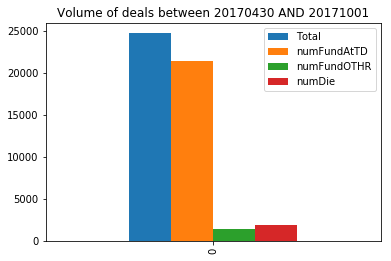

In [15]:
df.plot.bar(title = 'Volume of deals between 20170430 AND 20171001')